<a href="https://colab.research.google.com/github/rajeevfromkrec/pytorch/blob/master/2_layer_linear_model_on_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

In [3]:
dataset= MNIST(root='data/',download=True ,transform=ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
img,label= dataset[0]

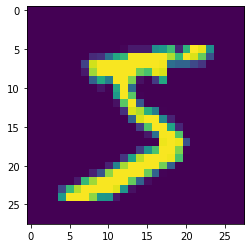

In [5]:
plt.imshow(img.reshape(-1,28))

In [6]:
val_size=10000
train_size=len(dataset)-val_size

train_load, val_load= random_split(dataset, [train_size, val_size])

In [7]:
batch_size =128

In [8]:
train_loader= DataLoader(train_load, batch_size,shuffle=True,num_workers=4,pin_memory=True)

In [9]:
val_loader =DataLoader(val_load, batch_size,num_workers=4, pin_memory=True)

torch.Size([128, 1, 28, 28])


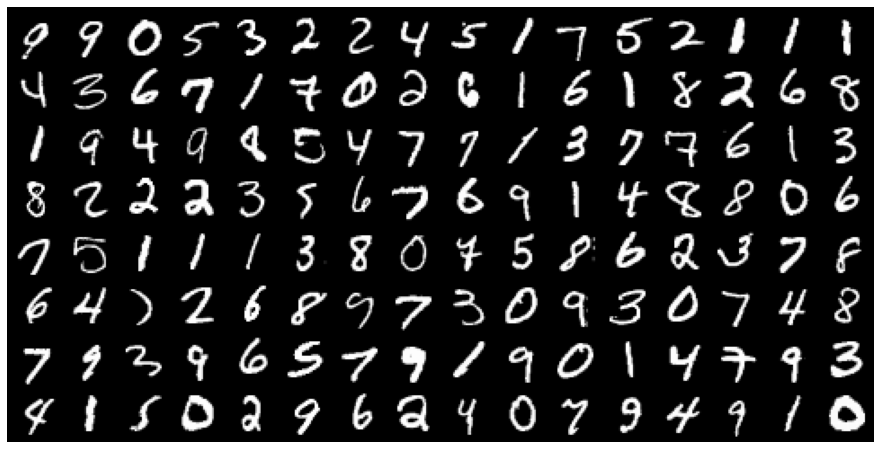

In [10]:
for images, _ in train_loader:
  print(images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
  break

In [11]:
def accuracy(output,labels):
  _, preds= torch.max(output,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))
  

In [12]:
class MnistModel(nn.Module):
  def __init__(self,in_size, hidden_size, out_size):
    super().__init__()
    self.linear1=nn.Linear(in_size, hidden_size)
    self.linear2=nn.Linear(hidden_size,out_size)

  def forward(self,xb):
    xb=xb.view(xb.size(0),-1)
    out=self.linear1(xb)
    out=F.relu(out)
    out=self.linear2(out)
    return out

  def training_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels  =batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    acc=accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [13]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [14]:
for images, labels in train_loader:
  outputs=model(images)
  loss=F.cross_entropy(outputs,labels)
  print(loss.item())
  break

2.310311794281006


In [15]:
torch.cuda.is_available()

True

In [16]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [17]:
device= get_default_device()
device

device(type='cuda')

In [18]:
def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return[to_device(x,device) for x in data]

  return data.to(device, non_blocking=True)
  


In [19]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [20]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [22]:
for xb, yb in val_loader:
  print(xb.device)
  print(yb)
  break

cuda:0
tensor([0, 9, 2, 8, 3, 7, 2, 7, 8, 7, 4, 8, 9, 4, 7, 5, 0, 1, 3, 7, 3, 4, 9, 5,
        5, 8, 3, 7, 4, 0, 8, 5, 7, 4, 6, 4, 3, 1, 0, 7, 2, 4, 6, 6, 8, 4, 8, 6,
        8, 0, 2, 0, 2, 1, 7, 9, 4, 7, 5, 2, 4, 0, 2, 0, 6, 0, 6, 9, 5, 3, 8, 3,
        5, 1, 4, 1, 0, 9, 5, 3, 9, 7, 8, 6, 8, 4, 4, 7, 7, 9, 2, 4, 1, 7, 9, 0,
        3, 3, 6, 2, 6, 0, 2, 9, 3, 3, 4, 9, 9, 2, 7, 6, 6, 8, 8, 4, 2, 1, 6, 9,
        4, 3, 6, 3, 3, 7, 9, 0], device='cuda:0')


In [23]:
def evaluate(model, val_loader):
  outputs=[model.validation_step(batches) for batches in val_loader]
  return model.validation_epoch_end(outputs)

In [24]:
def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
  history=[]
  optimizer=opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss=model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result=evaluate(model,val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [25]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [26]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.06437895447015762, 'val_loss': 2.3136870861053467}]

In [27]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2282, val_acc: 0.9302
Epoch [1], val_loss: 0.1597, val_acc: 0.9533
Epoch [2], val_loss: 0.1422, val_acc: 0.9593
Epoch [3], val_loss: 0.1478, val_acc: 0.9545
Epoch [4], val_loss: 0.1271, val_acc: 0.9639


In [28]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1327, val_acc: 0.9612
Epoch [1], val_loss: 0.1326, val_acc: 0.9613
Epoch [2], val_loss: 0.1274, val_acc: 0.9640
Epoch [3], val_loss: 0.1291, val_acc: 0.9620
Epoch [4], val_loss: 0.1266, val_acc: 0.9627
